In [1]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from generation import generate, get_lambda_max
from copy import deepcopy

In [2]:
n_train = 1000
n_test = 1000
k = 3
p = 10
rng = np.random.RandomState(0)
eps = 0.0001
fit_loss = 'l2'
reg = 'l1'

fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)

In [27]:
m = max(p, k)

_, D  = np.linalg.eigh(np.random.randn(m, m))
D = np.eye(m)
D = D[:k, :p]
D = np.random.randn(k, p) * np.arange(1, p + 1)
U, S, V = np.linalg.svd(D, full_matrices=False)
S = np.linspace(1, 10, min(p, k))
#S = np.ones(min(p, k))
D = np.dot(U * S[:, None], V)
D /= np.sqrt(np.sum(D ** 2, axis=0))

In [28]:
sigmas = np.linalg.svd(D)[1]

gap = sigmas[0] / sigmas[-1] - 1
print(sigmas)
print(gap)

[2.63254172 1.70345502 0.40983544]
5.423411539030412


In [29]:
D, X_train, X_test = generate(p, k, n_test, n_train, D=D, binary= fit_loss == 'logreg', rng=rng)
X_train /= get_lambda_max(D, X_train, fit_loss, False)
X_test /= get_lambda_max(D, X_test, fit_loss, False)
lbda_max = get_lambda_max(D, X_train, fit_loss)
print(lbda_max)

1.0000000000000002


In [30]:
lbda = 0.5

In [31]:
lista = LISTA(D, lbda, 2, variables='spectrum', learn_levels=False)
init_s = lista.spectra
print(lista.spectra)
print(lista.weights[0][0, 0])
lista.fit(X_train, backtrack=True, verbose=False, max_iter=1000)
print(lista.spectra)
print(lista.weights[0][0, 0])

[[0.37986103 0.24579902 0.05913696]
 [0.37986103 0.24579902 0.05913696]]
-0.008042650619208372
[[ 0.40024807  0.43609167  0.34164798]
 [ 0.38593693  0.21212996 -0.01864704]]
-0.06202012268300292


In [32]:
lista.spectra * init_s * lista.L

array([[ 1.05366975,  0.74286255,  0.14001945],
       [ 1.01599506,  0.36135384, -0.00764222]])

In [33]:
lbda = 0.5

In [34]:
f_min = LISTA(D, lbda, 1000).compute_loss(X_test)

In [44]:
n_layers = [2]
loss_lista = []
loss_slista = []

learn_levels = False

for n_layer in n_layers:
    print(n_layer)
    lista = LISTA(D, lbda, n_layer, variables='W1', learn_levels=learn_levels)
    if n_layer > 1:
        lista.weights[:len(old_weights)] = old_weights
    lista.fit(X_train, backtrack=True, verbose=200, max_iter=1000)
    old_weights = deepcopy(lista.weights)
    loss_lista.append(lista.compute_loss(X_test)- f_min)
    
    slista = LISTA(D, lbda, n_layer, variables='spectrum', learn_levels=learn_levels)
    if n_layer > 1:
        slista.spectra[:len(old_spectra)] = old_spectra
    slista.fit(X_train, backtrack=True, verbose=200, max_iter=1000)
    old_spectra = deepcopy(slista.spectra)
    loss_slista.append(slista.compute_loss(X_test) - f_min)

2
it 0, loss = 4.658e-01, grad_W = 2.72e-02, grad_l = 3.78e-02, l_rate = 1.00e-03
it 200, loss = 4.588e-01, grad_W = 1.73e-02, grad_l = 1.11e-01, l_rate = 2.56e-01
it 400, loss = 4.566e-01, grad_W = 1.52e-02, grad_l = 9.10e-02, l_rate = 1.28e-01
it 600, loss = 4.557e-01, grad_W = 1.23e-02, grad_l = 8.45e-02, l_rate = 1.28e-01
it 800, loss = 4.554e-01, grad_W = 1.21e-02, grad_l = 8.20e-02, l_rate = 1.28e-01
it 0, loss = 4.665e-01, grad_W = 2.64e-02, grad_l = 3.29e-02, l_rate = 1.00e-03
it 200, loss = 4.661e-01, grad_W = 3.66e-04, grad_l = 8.90e-02, l_rate = 4.10e+00
it 400, loss = 4.661e-01, grad_W = 2.16e-04, grad_l = 8.88e-02, l_rate = 2.05e+00
it 600, loss = 4.661e-01, grad_W = 1.28e-04, grad_l = 8.86e-02, l_rate = 2.05e+00
it 800, loss = 4.661e-01, grad_W = 9.36e-05, grad_l = 8.86e-02, l_rate = 2.05e+00


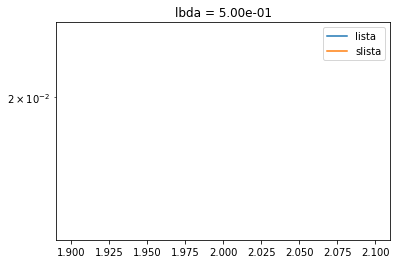

In [45]:
plt.figure()
plt.plot(n_layers, loss_lista, label='lista')
plt.plot(n_layers, loss_slista, label='slista')
plt.title('lbda = %.2e' % lbda)
plt.yscale('log')
plt.legend()
plt.show()

In [46]:
weights = old_weights
spectra = old_spectra

In [53]:
i = 1
W0 = weights[2 * i]
spectrum = old_spectra[i]

In [54]:
spectrum

array([ 0.38589281,  0.21006611, -0.02121017])

In [55]:
U, S, V = np.linalg.svd(W0, full_matrices=False)

In [56]:
S

array([1.2289467 , 0.81036522, 0.05881346])

In [57]:
Ud, Sd, Vd = np.linalg.svd(D.T, full_matrices=False)

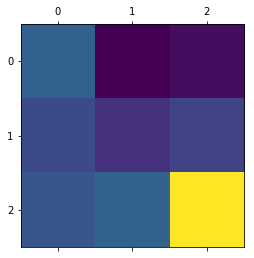

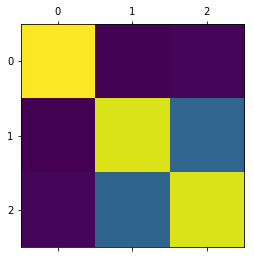

In [58]:
plt.matshow(np.abs(U.T @ Ud))
plt.matshow(np.abs(Vd.T @ V))